# Deepfake Image Detection

Autori: Bucă Mihnea-Vicențiu; Căpatână Răzvan-Nicolae; Luculescu Teodor

## Cross-generator deepfake detection

We want to evaluate the generalization capabilities of deepfake detection methods: how well detectors work when tested on images produced by other generators than those seen at training. For this, we will train on images coming from one generator and test on images coming from other generators. We will compare at least three different methods.

First method:
- We will use an image classification architecture, mainly ResNet, that will be trained from scratch.

Second method:
- The same architecture as above, but this time initialized with pre-trained weights. The weights will be obtained by supervised learning (image classification on ImageNet).


Third method:
- Large pretrained self-supervised representations followed by a linear classifier. In this case, only the linear classifier is trained; the representations are extracted with a frozen model. [Ojha et al., (2023)](https://github.com/WisconsinAIVision/UniversalFakeDetect) have used this approach in the context of deepfake detection, but differently from us, they have applied it to general fully-generated images. We will train two models, one using CLIP and one using SAM self-supervised representations and compare the results obtained.


For each method, fill in a table with the average precisions.

In this notebook we will use the **Third method**

### Data

The dataset can be downloaded from [here](https://drive.google.com/file/d/1NfLX9bZtOY8dO_yj3cU7pEHGmqItqjg2/view). It contains real images from the CelebAHQ dataset and locally manipulated images produced by four generators: [LDM](https://github.com/CompVis/latent-diffusion), [Pluralistic](https://github.com/lyndonzheng/Pluralistic-Inpainting), [LAMA](https://github.com/advimman/lama), [Repaint](https://github.com/andreas128/RePaint). You can read more about how this dataset was produced in Section 3.3 of the following paper:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We will extract the data for each model

In [ ]:
import zipfile
import os

# path to the zip file
zip_file_path = 'drive/MyDrive/Proiect DeepLearning/DeepFMI_local_data.zip'

# the paths to the datasets within the zip file
dataset_paths = [
    'FMI_local_data/celebhq_real_data',
    'FMI_local_data/lama',
    'FMI_local_data/ldm',
    'FMI_local_data/pluralistic',
    'FMI_local_data/repaint'
]

# create a ZipFile object
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Iterate through the dataset paths
    for dataset_path in dataset_paths:
         zip_ref.extractall(members=[
            name for name in zip_ref.namelist()
            if name.startswith(dataset_path)
        ], path='/content/')  # Extract to the '/content/' directory


In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-yet6fiue
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-yet6fiue
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-h33rns_r
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-h33rns_r
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=d60b754450bdbf417ba0bf2a6e462f95ba878567d9d4e365ff0e77ff98acbda3
  Stored in directory: /tmp/pip-ephem-wheel-cache-1tw76iry/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


## Training Models

In [ ]:
# important libraries
import os
import torch
import glob
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF

import numpy as np

import timm
import clip
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import accuracy_score

from torch.optim import AdamW
from segment_anything import sam_model_registry, SamPredictor
from IPython.display import display, Markdown
from sklearn.metrics import average_precision_score
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.models as models
from PIL import Image
from tqdm import tqdm  # for progress bar

In [ ]:
class DeepFakeDataset(Dataset):
    """
    Takes two folders (real vs fake) and assigns labels 0 / 1.
    """
    def __init__(self, real_folder: str, fake_folder: str, transform=None):
        # grab all .png under each
        self.real_paths = sorted(glob.glob(os.path.join(real_folder, '*.png')))
        self.fake_paths = sorted(glob.glob(os.path.join(fake_folder, '*.png')))

        # create a single list of (path, label)
        # real = 0, fake = 1
        self.samples = (
            [(p, 0) for p in self.real_paths] +
            [(p, 1) for p in self.fake_paths]
        )
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
import os
from torchvision import transforms
from torch.utils.data import DataLoader

def make_model_dataloaders(
    root_dir: str,            # contains subfolders: lama/, ldm/, repaint/, pluralistic/
    real_root: str,           # path to celebhq_real_data
    model_names: list[str],   # ['lama','ldm','repaint','pluralistic']
    splits: list[str] = ('train','valid','test'),
    batch_size: int = 16,
    img_size: int = 256,
    num_workers: int = 2
):
    """
    Returns:
      {
        'sam':   { model_name: { split: DataLoader, … }, … },
        'clip':  { model_name: { split: DataLoader, … }, … },
      }
     loaders['sam']['ldm']['train'], loaders['clip']['ldm']['valid']
    """

    # SAM-specific
    sam_tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),
                             (0.2023,0.1994,0.2010)),
    ])

    # CLIP-specific
    clip_tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4815,0.4578,0.4081),
                             (0.2686,0.2613,0.2758)),
    ])

    # container for three "modes"
    loaders = {mode: {} for mode in ('base','sam','clip')}

    for mode, tf in [('sam', sam_tf), ('clip', clip_tf)]:
        for model_name in model_names:
            loaders[mode].setdefault(model_name, {})
            for split in splits:
                real_folder = os.path.join(real_root, split)
                fake_folder = os.path.join(root_dir, model_name, split)

                # pick transform
                if mode == 'sam':
                    transform = sam_tf
                elif mode == 'clip':
                    transform = clip_tf

                # create dataset
                ds = DeepFakeDataset(real_folder, fake_folder, transform=transform)
                loaders[mode][model_name][split] = DataLoader(
                    ds,
                    batch_size=batch_size,
                    shuffle=(split == 'train'),
                    num_workers=num_workers,
                    pin_memory=True
                )

    return loaders


In [ ]:
root = "/content/FMI_local_data"
deepfake_models = ["lama", "ldm", "repaint", "pluralistic"]
loaders = make_model_dataloaders(
    root_dir=root,
    real_root=os.path.join(root, "celebhq_real_data"),
    model_names=deepfake_models,
    splits=['train', 'valid', 'test'],
    batch_size=16,
    img_size=256,
    num_workers=2
)

# test
ldm_train_loader = loaders['clip']['ldm']['train']
print(f"ldm train batches: {len(ldm_train_loader)}")

ldm train batches: 1125


#### CLIP

In [ ]:
def train_clip(
    dataloaders: dict,
    num_classes: int = 2,
    num_epochs: int = 5,
    lr: float = 1e-3,
    device: str = None,
    clip_size: int = 224
):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

    clip_model, _ = clip.load("ViT-B/32", device=device)
    visual = clip_model.visual.eval().float()
    for p in visual.parameters():
        p.requires_grad = False

    feat_dim = visual.output_dim
    results = {}

    for gen, splits in dataloaders.items():
        print(f"\n=== [CLIP] probe on '{gen}' ===")
        head = nn.Linear(feat_dim, num_classes).to(device)
        opt  = optim.Adam(head.parameters(), lr=lr)
        crit = nn.CrossEntropyLoss()

        # --- Training ---
        for epoch in range(1, num_epochs+1):
            head.train()
            total_loss = 0.0
            count = 0
            for imgs, labels in splits['train']:
                imgs, labels = imgs.to(device), labels.to(device)

                with torch.no_grad():
                    feats = visual(imgs).flatten(1)  # (B, feat_dim)
                logits = head(feats)
                loss = crit(logits, labels)

                opt.zero_grad()
                loss.backward()
                opt.step()

                total_loss += loss.item() * imgs.size(0)
                count += imgs.size(0)

            avg_loss = total_loss / count
            print(f"  Epoch {epoch}/{num_epochs} — head loss: {avg_loss:.4f}")

            # --- Validation ---
            head.eval()
            all_preds, all_labels = [], []
            with torch.no_grad():
                for imgs, labels in splits['valid']:
                    imgs = imgs.to(device)
                    feats = visual(imgs).flatten(1)
                    preds = head(feats).argmax(1).cpu().tolist()

                    all_preds.extend(preds)
                    all_labels.extend(labels.tolist())

            valid_acc = accuracy_score(all_labels, all_preds)
            print(f"  ▶ Validation accuracy: {valid_acc:.2%}")

            results[gen] = {'head': head, 'valid_acc': valid_acc}

    return results

In [ ]:
clip_results = train_clip(loaders['clip'], num_classes=2, num_epochs=5, lr=1e-3)


=== [CLIP] probe on 'lama' ===
  Epoch 1/5 — head loss: 0.2594
  Epoch 2/5 — head loss: 0.0954
  Epoch 3/5 — head loss: 0.0605
  Epoch 4/5 — head loss: 0.0444
  Epoch 5/5 — head loss: 0.0350
  ▶ Validation accuracy: 99.28%

=== [CLIP] probe on 'ldm' ===
  Epoch 1/5 — head loss: 0.2772
  Epoch 2/5 — head loss: 0.1146
  Epoch 3/5 — head loss: 0.0793
  Epoch 4/5 — head loss: 0.0624
  Epoch 5/5 — head loss: 0.0525
  ▶ Validation accuracy: 98.11%

=== [CLIP] probe on 'repaint' ===
  Epoch 1/5 — head loss: 0.6395
  Epoch 2/5 — head loss: 0.6145
  Epoch 3/5 — head loss: 0.6081
  Epoch 4/5 — head loss: 0.6022
  Epoch 5/5 — head loss: 0.5990
  ▶ Validation accuracy: 65.00%

=== [CLIP] probe on 'pluralistic' ===
  Epoch 1/5 — head loss: 0.3261
  Epoch 2/5 — head loss: 0.1986
  Epoch 3/5 — head loss: 0.1678
  Epoch 4/5 — head loss: 0.1520
  Epoch 5/5 — head loss: 0.1426
  ▶ Validation accuracy: 94.22%


In [ ]:
save_path = 'drive/MyDrive/Proiect DeepLearning/Task-1/Third-Method/clip_results.pth'
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Ensure the directory exists
torch.save(clip_results, save_path)
print(f"Results saved to: {save_path}")

Results saved to: drive/MyDrive/Proiect DeepLearning/Third-Method/clip_results.pth


In [ ]:
def build_cross_table_clip(
    results: dict,
    dataloaders: dict,
    device: str = None,
    clip_size: int = 224
) -> pd.DataFrame:
    """
    Cross‐table of macro‐AP for CLIP+linear‐head classifiers.
    Expects `results[gen]['head']` to be the trained nn.Linear,
    and `dataloaders[gen]['test']` to yield (B,3,224,224),label.
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # load and freeze CLIP visual encoder
    clip_model, _ = clip.load("ViT-B/32", device=device)
    visual = clip_model.visual.eval().float()
    for p in visual.parameters():
        p.requires_grad = False

    gens = list(results.keys())
    table = pd.DataFrame(index=gens, columns=gens, dtype=float)

    for train_gen, result_dict in results.items():
        head = result_dict["head"].to(device).eval()

        with torch.no_grad():
            for test_gen in gens:
                all_probs = []
                all_targets = []

                for imgs, labels in dataloaders[test_gen]["test"]:
                    imgs = imgs.to(device)
                    feats = visual(imgs).flatten(1)  # (B, feat_dim)
                    logits = head(feats)
                    probs = torch.softmax(logits, dim=1).cpu().numpy()

                    all_probs.append(probs)
                    all_targets.append(labels.numpy())

                all_probs = np.concatenate(all_probs, axis=0)
                all_targets = np.concatenate(all_targets, axis=0)
                onehot   = np.eye(all_probs.shape[1])[all_targets]

                ap = average_precision_score(onehot, all_probs, average="macro")
                table.loc[test_gen, train_gen] = ap

    return table

In [ ]:
df = build_cross_table_clip(clip_results, loaders['clip'])
print("\nCross-Generator Accuracy Table:\n")
display(Markdown(df.to_markdown(floatfmt=".3f")))


Cross-Generator Accuracy Table:



|             |   lama |   ldm |   repaint |   pluralistic |
|:------------|-------:|------:|----------:|--------------:|
| lama        |  1.000 | 0.535 |     0.522 |         0.675 |
| ldm         |  0.600 | 1.000 |     0.901 |         0.977 |
| repaint     |  0.511 | 0.620 |     0.723 |         0.615 |
| pluralistic |  0.765 | 0.951 |     0.880 |         0.992 |

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
torch.serialization.add_safe_globals([timm.models.xception_aligned.XceptionAligned])
# Load the model and map to the appropriate device
tmp = torch.load("drive/MyDrive/Proiect DeepLearning/Third-Method/clip_results.pth", map_location=torch.device(device), weights_only=False)

Using device: cpu


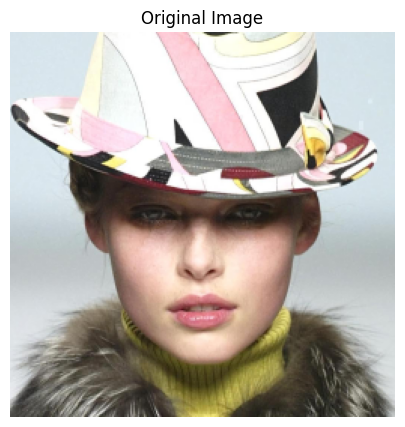

In [ ]:
originals = []
cnt = 0
ds = loaders['clip']['lama']['test'].dataset
for path, lbl in ds.samples:
    if lbl == 0:
        if path.find("10503"):
            originals.append(Image.open(path).convert('RGB'))
            break


fig, axes = plt.subplots(1, 1, figsize=(15, 5))
axes.imshow(originals[0])
axes.set_title(f"Original Image")
axes.axis('off')

plt.show()

/content/FMI_local_data/lama/test/10503-2.png
/content/FMI_local_data/ldm/test/10503-2.png
/content/FMI_local_data/repaint/test/10503-2.png
/content/FMI_local_data/pluralistic/test/10503-2.png


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


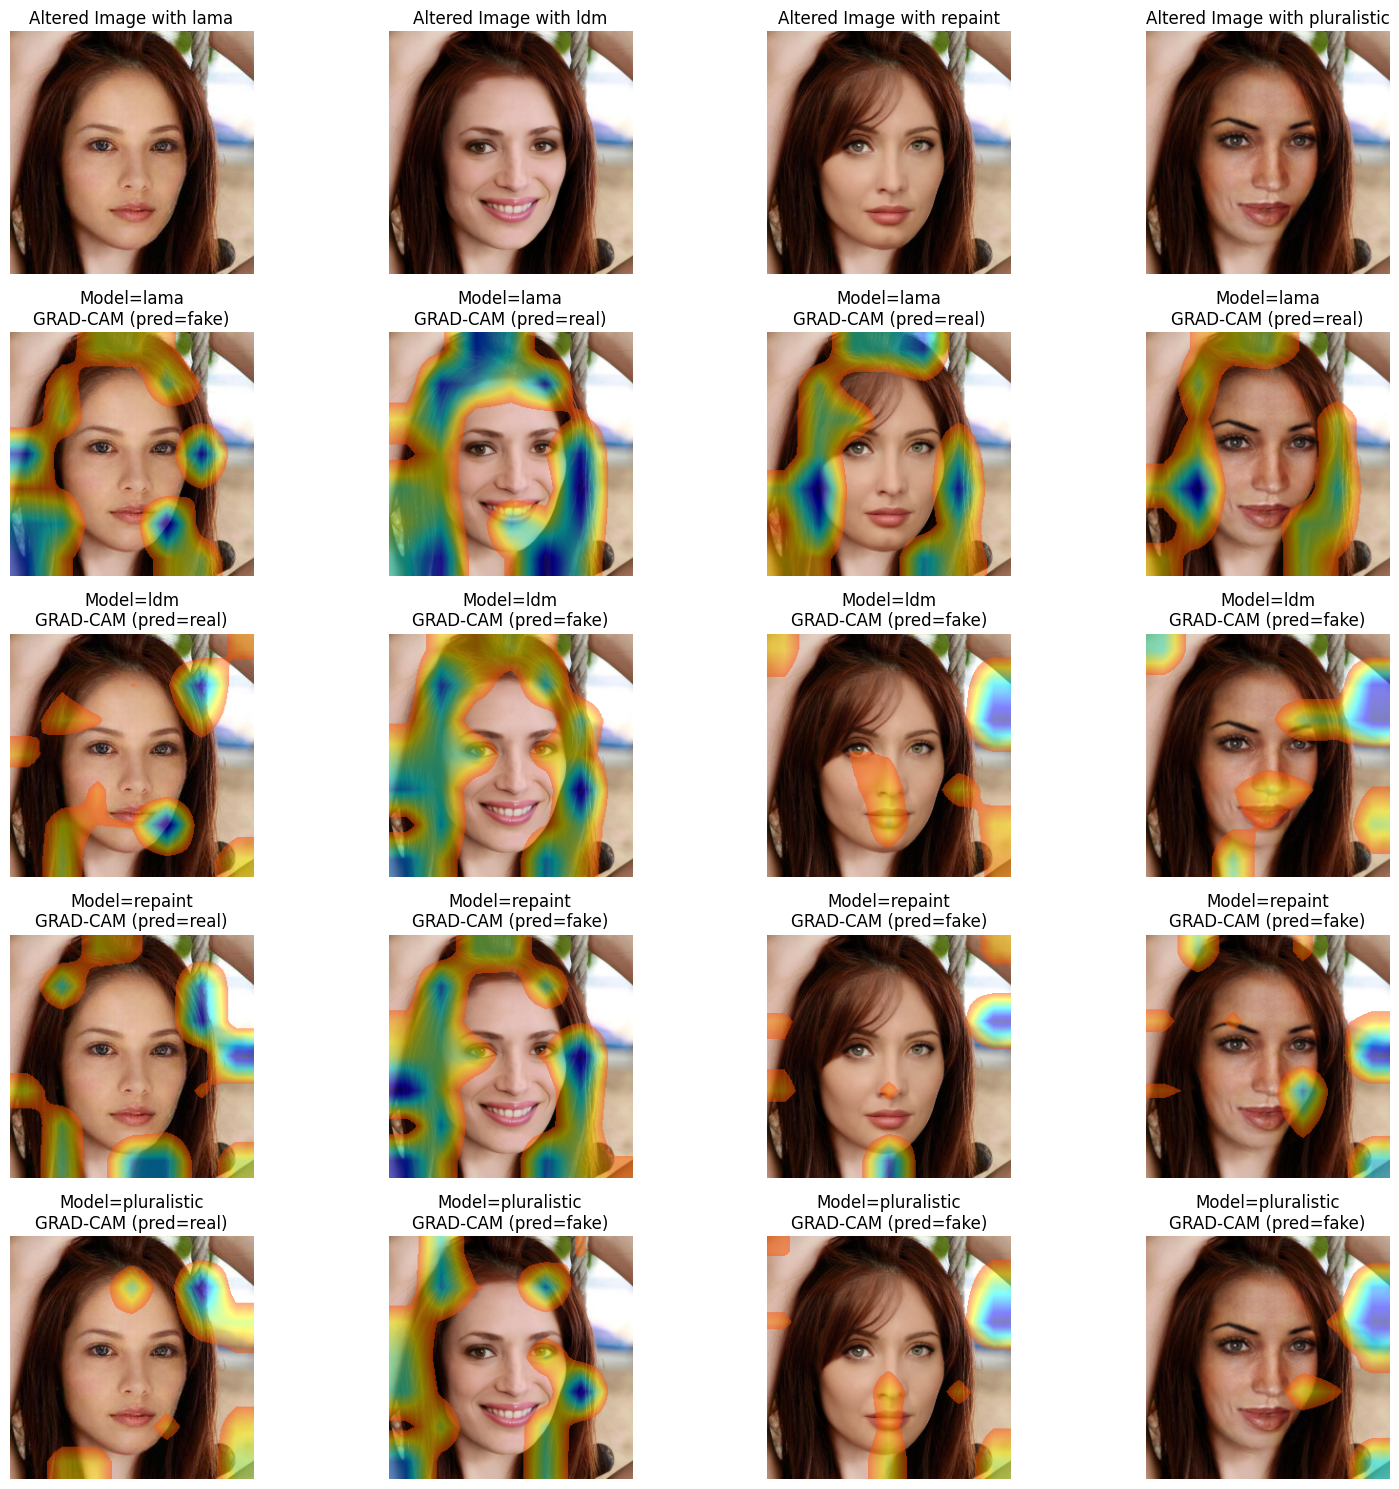

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision import transforms
from PIL import Image
import clip

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1) Load CLIP base and your heads
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()

# A wrapper combining CLIP visual + your linear head
class CombinedModel(torch.nn.Module):
    def __init__(self, visual, head):
        super().__init__()
        self.visual = visual
        self.head   = head
    def forward(self, x):
        # x: preprocessed image
        feats = self.visual(x)             # [1, dim]
        return self.head(feats)            # [1, num_classes]

# 2) Grad‑CAM hooking on the patch‑embed conv1
class GradCAM:
    def __init__(self, model, layer):
        self.model = model.eval().to(device)
        self.layer = layer
        self.grad  = None
        layer.register_backward_hook(lambda m, gi, go: setattr(self, 'grad', go[0].detach()))

    def __call__(self, x, class_idx=1):
        # capture feature map
        hook = self.layer.register_forward_hook(lambda m, inp, out: setattr(self, 'fmap', out.detach()))
        logits = self.model(x)
        hook.remove()

        # backprop on fake
        self.model.zero_grad()
        logits[0, class_idx].backward(retain_graph=True)

        grads = self.grad[0]    # (C,H,W)
        fmap  = self.fmap[0]    # (C,H,W)
        weights = grads.view(grads.size(0), -1).mean(1)
        cam = (weights[:,None,None] * fmap).sum(0).relu()
        cam = (cam - cam.min())/(cam.max()-cam.min())
        return cam.cpu().numpy(), torch.argmax(logits, dim=1).item()

# 3) Overlay with thresholded JET
def overlay_heat(orig_np, cam, alpha=0.5, thresh=0.2):
    h, w = orig_np.shape[:2]
    cam_r = cv2.resize(cam, (w,h))
    cam_u = np.uint8(255 * cam_r)
    heat = cv2.applyColorMap(cam_u, cv2.COLORMAP_JET)
    mask = cam_r > thresh
    out = orig_np.copy()
    out[mask] = cv2.addWeighted(orig_np, 1-alpha, heat, alpha, 0)[mask]
    return out

# 4) Preproc for CLIP
preproc = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                         std=(0.26862954, 0.26130258, 0.27577711))
])

domains = ['lama','ldm','repaint','pluralistic']

# 5) Grab one fake=1 PNG per domain
originals = []
for d in domains:
    cnt = 0
    ds = loaders['clip'][d]['test'].dataset
    for path, lbl in ds.samples:
        if lbl == 1:
            cnt += 1
            if cnt < 30:
                continue
            originals.append(Image.open(path).convert('RGB'))
            print(path)
            break

# 6) Plot: 1 row originals + 4 rows (one per head)
model_keys = list(tmp.keys())
fig, axes = plt.subplots(1 + len(model_keys), len(domains),
                         figsize=(4*len(domains), 3*(1+len(model_keys))))

# Top row: originals
for j, img in enumerate(originals):
    axes[0,j].imshow(np.array(img))
    axes[0,j].set_title(f"Altered Image with {domains[j]}")
    axes[0,j].axis('off')

# Rows per head
for i, mk in enumerate(model_keys, start=1):
    head = tmp[mk]['head'].to(device).eval()
    combined = CombinedModel(clip_model.visual, head)
    # hook the first conv in the patch embed
    layer = clip_model.visual.conv1
    camer = GradCAM(combined, layer)

    for j, img in enumerate(originals):
        x = preproc(img).unsqueeze(0).to(device)
        cam, pred = camer(x)
        blended = overlay_heat(np.array(img), cam)

        label = 'fake' if pred==1 else 'real'
        axes[i,j].imshow(blended)
        axes[i,j].set_title(f"Model={mk}\nGRAD-CAM (pred={label})")
        axes[i,j].axis('off')

plt.tight_layout()
plt.show()


#### SAM

In [ ]:
class SamClassifier(nn.Module):
    """
    A classifier that uses a frozen SAM image encoder backbone
    and a trainable linear head for classification.
    """
    def __init__(self, image_encoder: nn.Module, num_classes: int):
        super().__init__()
        # Use the SAM image encoder as backbone (frozen elsewhere)
        self.backbone = image_encoder
        # Linear head: assume backbone outputs 256 channels after pooling
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        # Get image embeddings from SAM (shape: [B, 256, H, W])
        embeddings = self.backbone(x)
        # Global average pool over spatial dims -> [B, 256]
        pooled = embeddings.mean(dim=(2, 3))
        # Linear classification head
        return self.classifier(pooled)

In [ ]:

def train_sam(dataloaders: dict, num_classes: int, num_epochs: int,
              lr: float, accumulation_steps: int,
              weight_decay: float, device: torch.device):
    results = {}

    # Load SAM ViT-B backbone with pretrained checkpoint
    # (Assumes checkpoint downloaded; see segment-anything README for download links&#8203;:contentReference[oaicite:3]{index=3}.)
    sam = sam_model_registry["vit_b"](checkpoint="/content/sam_vit_b_01ec64.pth")
    sam.eval()

    # Adapt backbone for 256x256 inputs
    # - Set image encoder expected size
    sam.image_encoder.img_size = 256

    # - Compute new grid dimensions
    patch_size = sam.image_encoder.patch_embed.proj.stride[0]  # typically 16
    new_grid = 256 // patch_size

    if getattr(sam.image_encoder, "pos_embed", None) is not None:
        pos_embed = sam.image_encoder.pos_embed  # shape [1, H_old, W_old, C]
        H_old, W_old = pos_embed.shape[1], pos_embed.shape[2]
        if (H_old != new_grid) or (W_old != new_grid):
            # Interpolate to new size
            pe = pos_embed.data.reshape(1, H_old, W_old, -1).permute(0, 3, 1, 2)  # -> [1, C, H_old, W_old]
            pe = F.interpolate(pe, size=(new_grid, new_grid), mode='bilinear', align_corners=False)
            pe = pe.permute(0, 2, 3, 1)  # -> [1, H_new, W_new, C]
            sam.image_encoder.pos_embed = nn.Parameter(pe)

    # Freeze SAM backbone parameters
    for param in sam.parameters():
        param.requires_grad = False

    # For each dataset, train a new linear head
    for name, loaders in dataloaders.items():
        print(f"\n=== [SAM] probe on '{name}' ===")
        train_loader = loaders["train"]
        valid_loader = loaders["valid"]

        # Initialize model (with frozen SAM image encoder)
        model = SamClassifier(sam.image_encoder, num_classes).to(device)
        model.backbone = sam.image_encoder  # reference frozen backbone
        # Ensure backbone stays frozen
        for param in model.backbone.parameters():
            param.requires_grad = False

        # Loss and optimizer (only classifier parameters are trainable)
        criterion = nn.CrossEntropyLoss()
        optimizer = AdamW(model.classifier.parameters(), lr=lr, weight_decay=weight_decay)

        # Training loop
        for epoch in range(1, num_epochs + 1):
            model.train()
            total_loss = 0.0
            optimizer.zero_grad()

            for i, (images, labels) in enumerate(train_loader, start=1):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                (loss / accumulation_steps).backward()

                # Gradient accumulation step
                if (i % accumulation_steps == 0) or (i == len(train_loader)):
                    optimizer.step()
                    optimizer.zero_grad()

            avg_train_loss = total_loss / len(train_loader)

            # Validation pass
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in valid_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    preds = outputs.argmax(dim=1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)

            avg_val_loss = val_loss / len(valid_loader)
            val_acc = correct / total

            print(f"[{name}] Epoch {epoch}/{num_epochs} | "
                  f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Save the trained model and final validation accuracy
        results[name] = (model, val_acc)

    return results

In [ ]:
sam_results = train_sam(
    dataloaders=loaders['sam'], # Pass the inner dict {"train":..., "val":...}
    num_classes=2,
    num_epochs=1,
    lr=1e-3,
    weight_decay=0.01,
    accumulation_steps=1,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)


=== [SAM] probe on 'lama' ===
[lama] Epoch 1/1 | Train Loss: 0.6380 | Val Loss: 0.5950

=== [SAM] probe on 'ldm' ===
[ldm] Epoch 1/1 | Train Loss: 0.6803 | Val Loss: 0.6649

=== [SAM] probe on 'repaint' ===
[repaint] Epoch 1/1 | Train Loss: 0.6908 | Val Loss: 0.6904

=== [SAM] probe on 'pluralistic' ===
[pluralistic] Epoch 1/1 | Train Loss: 0.6805 | Val Loss: 0.6723


In [ ]:
save_path = 'drive/MyDrive/Proiect DeepLearning/Task-1/Third-Method/sam__results.pth'
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Ensure the directory exists
torch.save(sam_results, save_path)
print(f"Results saved to: {save_path}")

Results saved to: drive/MyDrive/Proiect DeepLearning/Third-Method/sam__results.pth


In [ ]:
def build_cross_table_sam(
    results: dict,
    dataloaders: dict,
    device: str = None,
    checkpoint: str = "/content/sam_vit_b_01ec64.pth"
) -> pd.DataFrame:
    """
    Cross‐table of macro‐AP for SAM+linear‐head classifiers.
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Load & freeze SAM image encoder, adapt to 256×256
    sam = sam_model_registry["vit_b"](checkpoint=checkpoint).to(device).eval()
    for p in sam.parameters():
        p.requires_grad = False

    # Adapt SAM to 256×256 inputs
    sam.image_encoder.img_size = 256
    patch_size = sam.image_encoder.patch_embed.proj.stride[0]
    grid = 256 // patch_size
    # Resize positional embeddings if present
    if hasattr(sam.image_encoder, "pos_embed"):
        pe = sam.image_encoder.pos_embed          # [1, H_old, W_old, C]
        H_old, W_old, C = pe.shape[1], pe.shape[2], pe.shape[3]
        pe = pe.reshape(1, H_old, W_old, C).permute(0, 3, 1, 2)  # [1,C,H_old,W_old]
        pe = F.interpolate(pe, size=(grid, grid), mode="bicubic", align_corners=False)
        pe = pe.permute(0, 2, 3, 1).reshape(1, grid, grid, C)
        sam.image_encoder.pos_embed = nn.Parameter(pe)

    gens = list(results.keys())
    table = pd.DataFrame(index=gens, columns=gens, dtype=float)

    # 2) Cross‐evaluate
    for train_gen, result_dict in results.items():
        # grab the trained linear head
        # Accessing the model using index 0 of the tuple
        head: nn.Linear = result_dict[0].classifier.to(device).eval() # Access the classifier instead of the model

        with torch.no_grad():
            for test_gen in gens:
                all_probs = []
                all_targets = []

                for imgs, labels in dataloaders[test_gen]["test"]:
                    imgs = imgs.to(device)
                    labels = labels.cpu().numpy()

                    # 2a) SAM feature extraction
                    feats = sam.image_encoder(imgs)      # [B, C, H, W]
                    pooled = feats.mean(dim=(2, 3))      # [B, C]

                    # 2b) classification
                    logits = head(pooled)                # [B, num_classes]
                    probs = torch.softmax(logits, dim=1).cpu().numpy()

                    all_probs.append(probs)
                    all_targets.append(labels)

                all_probs = np.concatenate(all_probs, axis=0)
                all_targets = np.concatenate(all_targets, axis=0)
                onehot = np.eye(all_probs.shape[1])[all_targets]

                ap = average_precision_score(onehot, all_probs, average="macro")
                table.loc[train_gen, test_gen] = ap # fixed the order of train_gen and test_gen

    return table

In [ ]:
df = build_cross_table_sam(sam_results, loaders['sam'])
print("\nCross-Generator Accuracy Table:\n")
display(Markdown(df.to_markdown(floatfmt=".3f")))


Cross-Generator Accuracy Table:



|             |   lama |   ldm |   repaint |   pluralistic |
|:------------|-------:|------:|----------:|--------------:|
| lama        |  0.870 | 0.420 |     0.514 |         0.588 |
| ldm         |  0.349 | 0.741 |     0.552 |         0.561 |
| repaint     |  0.536 | 0.543 |     0.547 |         0.575 |
| pluralistic |  0.647 | 0.527 |     0.543 |         0.627 |